# Resnet34

In [3]:
import os
import numpy as np
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.utils import shuffle

# ✅ Paths (Update to your dataset path)
DATASET_DIR = r"C:\Users\Dines\OneDrive\Desktop\a\images"
IMG_SIZE = 224  
BATCH_SIZE = 32  

# ✅ Check if dataset exists
if not os.path.exists(DATASET_DIR):
    raise ValueError(f"Dataset directory '{DATASET_DIR}' not found!")

def load_images(folder, label):
    """Loads images from a folder and assigns a label (0 = real, 1 = fake)."""
    images, labels = [], []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)

        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # Convert BGR to RGB
            images.append(img)
            labels.append(label)
    
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int32)

# ✅ Load images from "real" and "fake" folders
real_images, real_labels = load_images(os.path.join(DATASET_DIR, "real"), label=0)
fake_images, fake_labels = load_images(os.path.join(DATASET_DIR, "fake"), label=1)

# ✅ Combine and shuffle dataset
X = np.concatenate((real_images, fake_images), axis=0)
y = np.concatenate((real_labels, fake_labels), axis=0)
X, y = shuffle(X, y, random_state=42)

# ✅ Normalize images (ResNet expects values in [-1,1] range)
X = (X / 127.5) - 1.0

# ✅ Split into train (80%), val (10%), test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ✅ Convert labels to categorical (for softmax)
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# ✅ Create TensorFlow dataset pipeline
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# ✅ Print dataset sizes
print(f"✅ Preprocessing complete! Loaded dataset from '{DATASET_DIR}'")
print(f"Real images: {len(real_images)} | Fake images: {len(fake_images)}")
print(f"Training: {X_train.shape[0]} | Validation: {X_val.shape[0]} | Testing: {X_test.shape[0]}")


✅ Preprocessing complete! Loaded dataset from 'C:\Users\Dines\OneDrive\Desktop\a\images'
Real images: 900 | Fake images: 900
Training: 1440 | Validation: 180 | Testing: 180


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import AdamW

# ✅ Learning rate schedule (Cosine Decay)
def cosine_decay(epoch):
    initial_lr = 0.0005  # Reduced LR compared to ResNet-50
    return float(initial_lr * 0.5 * (1 + tf.math.cos(epoch / 40 * 3.1416)))  # 40 epochs

# ✅ ResNet Block
def resnet_block(inputs, filters, kernel_size=3, stride=1):
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2D(filters, kernel_size, strides=1, padding="same",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.BatchNormalization()(x)

    shortcut = layers.Conv2D(filters, 1, strides=stride, padding="same",
                             kernel_regularizer=regularizers.l2(1e-4))(inputs)
    shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Add()([x, shortcut])
    x = layers.ReLU()(x)
    return x

# ✅ ResNet-34 Model
def build_resnet34(input_shape=(224, 224, 3), num_classes=2):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(64, 7, strides=2, padding="same", kernel_regularizer=regularizers.l2(1e-4))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding="same")(x)

    # 🔹 Reduced layers (ResNet-34 style)
    filter_sizes = [64, 128, 256, 512]
    num_blocks = [3, 4, 6, 3]  # Original ResNet-34 architecture

    for filters, blocks in zip(filter_sizes, num_blocks):
        for i in range(blocks):
            stride = 2 if i == 0 else 1  # First block in each layer reduces size
            x = resnet_block(x, filters, stride=stride)

    # 🔹 Final Layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)  # Higher dropout than ResNet-50 for regularization
    x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model

# ✅ Compile Model
model = build_resnet34()
model.compile(
    optimizer=AdamW(learning_rate=0.0005, weight_decay=1e-4),  # Lower LR than ResNet-50
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# ✅ Callbacks
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)
lr_scheduler = keras.callbacks.LearningRateScheduler(cosine_decay)

# ✅ Model Checkpoint (Save best model)
checkpoint_filepath = "resnet34_model.h5"
model_checkpoint = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath, monitor="val_loss", save_best_only=True, verbose=1
)

# ✅ Train Model
history = model.fit(
    train_data, validation_data=val_data, epochs=40,  # Reduced epochs
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)

# ✅ Load Best Model & Evaluate
best_model = keras.models.load_model(checkpoint_filepath)
test_loss, test_acc = best_model.evaluate(test_data)

print(f"✅ Best Model Saved at Val Loss: {min(history.history['val_loss']):.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5662 - loss: 2.0386  
Epoch 1: val_loss improved from inf to 1.86334, saving model to resnet34_model.h5


45/45 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.5673 - loss: 2.0361 - val_accuracy: 0.5000 - val_loss: 1.8633 - learning_rate: 5.0000e-04
Epoch 2/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7659 - loss: 1.6137  
Epoch 2: val_loss did not improve from 1.86334
45/45 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.7665 - loss: 1.6131 - val_accuracy: 0.5000 - val_loss: 2.8605 - learning_rate: 4.9923e-04
Epoch 3/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8132 - loss: 1.5484  
Epoch 3: val_loss did not improve from 1.86334
45/45 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.8132 - loss: 1.5484 - val_accuracy: 0.5000 - val_loss: 14.2569 - learning_rate: 4.9692e-04
Epoch 4/40
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8336 - loss: 1.4904  
Epoch 4: val_loss did not improve from 1.86334
45/45 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.8340 - loss: 1.4897 - val_accuracy: 0.5000 - val_loss: 7.6986 - learning_rate: 4.9309e-04
Epoch 5/40
45/45 ━━━━━━━━━━

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 403ms/step - accuracy: 0.5015 - loss: 1.8621
✅ Best Model Saved at Val Loss: 1.8633
Test Accuracy: 0.5000


In [5]:
from tensorflow.keras.models import load_model

# ✅ Load the best saved model
model = load_model("resnet34_model.h5")

# ✅ Print model summary to confirm it's loaded correctly
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_49 (Conv2D)            │ (None, 112, 112, 64)      │           9,472 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_49        │ (None, 112, 112, 64)      │             256 │ conv2d_49[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_33 (ReLU)               │ (None, 112, 112, 64)      │               0 │ batch_normalization_49[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 56, 56, 64)        │               0 │ re_lu_33[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_50 (Conv2D)            │ (None, 28, 28, 64)        │          36,928 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_50        │ (None, 28, 28, 64)        │             256 │ conv2d_50[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_34 (ReLU)               │ (None, 28, 28, 64)        │               0 │ batch_normalization_50[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_51 (Conv2D)            │ (None, 28, 28, 64)        │          36,928 │ re_lu_34[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_52 (Conv2D)            │ (None, 28, 28, 64)        │           4,160 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_51        │ (None, 28, 28, 64)        │             256 │ conv2d_51[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_52        │ (None, 28, 28, 64)        │             256 │ conv2d_52[0][0]            │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_16 (Add)                  │ (None, 28, 28, 64)        │               0 │ batch_normalization_51[0]… │
│                               │                           │                 │ batch_normalization_52[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_35 (ReLU)               │ (None, 28, 28, 64)        │               0 │ add_16[0][0]               │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 22,501,700 (85.84 MB)

 Trainable params: 22,478,914 (85.75 MB)

 Non-trainable params: 22,784 (89.00 KB)

 Optimizer params: 2 (12.00 B)

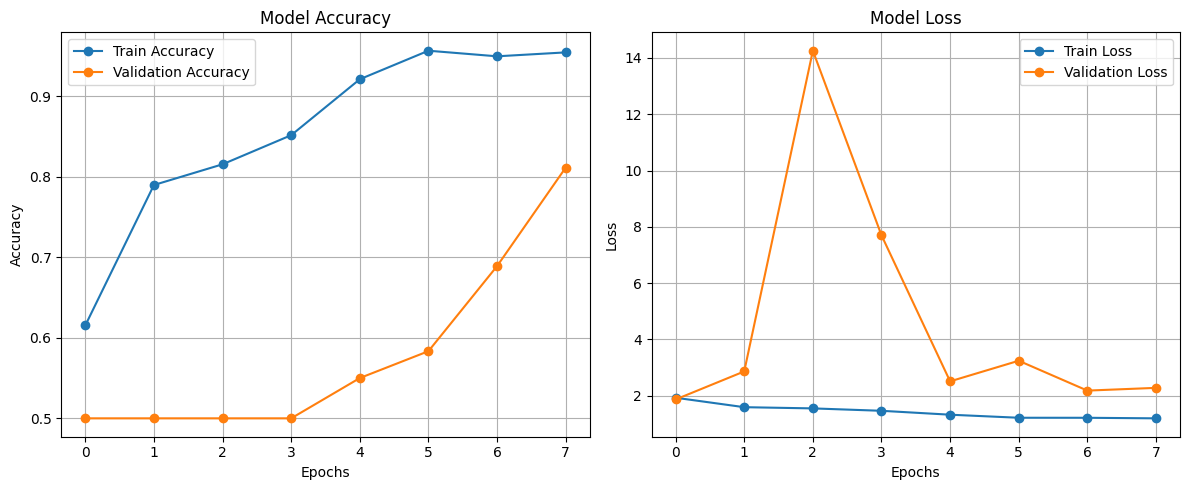

In [6]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """Plot training & validation accuracy and loss."""
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # ✅ Accuracy Plot
    ax[0].plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Model Accuracy')
    ax[0].legend()
    ax[0].grid(True)

    # ✅ Loss Plot
    ax[1].plot(history.history['loss'], label='Train Loss', marker='o')
    ax[1].plot(history.history['val_loss'], label='Validation Loss', marker='o')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Model Loss')
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# ✅ Call function after training
plot_training_history(history)


📊 Classification Report:
               precision    recall  f1-score   support

        Real       0.49      0.49      0.49        90
        Fake       0.49      0.49      0.49        90

    accuracy                           0.49       180
   macro avg       0.49      0.49      0.49       180
weighted avg       0.49      0.49      0.49       180



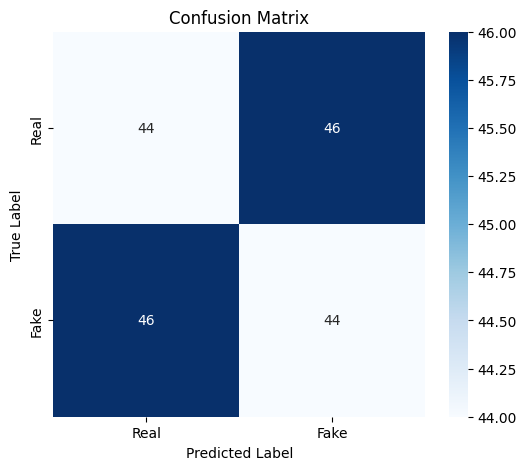

In [22]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are the actual and predicted labels
# Ensure y_test and y_pred are 1D arrays with single-label classification
if len(y_test.shape) > 1:  # In case they are multilabel
    y_test = np.argmax(y_test, axis=1)
if len(y_val.shape) > 1:  # In case predictions are multilabel
    y_val = np.argmax(y_val, axis=1)

# Print classification report
print("📊 Classification Report:\n", classification_report(y_test, y_val, target_names=["Real", "Fake"]))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_val)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title("Confusion Matrix")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [2]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import os

# ✅ Load the trained ResNet34 model
MODEL_PATH = "resnet34_model.h5"  # Make sure this is the correct model path
model = load_model(MODEL_PATH, compile=False)

# ResNet34 expects 224x224x3 input
IMG_SIZE = 224  
CHANNELS = 3    

# ✅ Function to preprocess a single image
def preprocess_image(image_path):
    if not os.path.exists(image_path):
        raise ValueError(f"❌ Image not found: {image_path}")

    img = cv2.imread(image_path)  # Load image
    if img is None:
        raise ValueError(f"❌ Unable to load image: {image_path}")

    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 224x224
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB (ResNet34 expects RGB)
    
    # ✅ Correct normalization for ResNet34 (values in [-1,1])
    img = (img / 127.5) - 1.0  
    
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# ✅ Function to make a prediction
def predict_image(image_path):
    try:
        img = preprocess_image(image_path)  # Preprocess input image
        prediction = model.predict(img)[0]  # Get prediction probabilities
        
        class_names = ["✅ Real CT Scan (Class 0)", "❌ Fake CT Scan (Class 1)"]
        predicted_class = np.argmax(prediction)  # Get class with highest probability
        confidence = prediction[predicted_class] * 100  # Convert to percentage
        
        print(f"Prediction: {confidence:.2f}% → {class_names[predicted_class]}")
    
    except Exception as e:
        print(f"⚠️ Error: {e}")

# ✅ Example usage
IMAGE_PATH = r"C:\Users\uppal\OneDrive\Desktop\a\f1.png"  # Change this to your test image path
predict_image(IMAGE_PATH)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: 62.26% → ✅ Real CT Scan (Class 0)


In [3]:
len(model.layers)

154